In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext Cython
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import scipy
import scipy.misc as scmisc
import scipy.special as ss
import scipy.linalg as sl
import scipy.integrate as si
import scipy.interpolate as interp
import scipy.constants as sc
import scipy.optimize as sopt
import scipy.stats as scistats
import sys,os,glob,h5py
import cPickle as pickle

import PTMCMCSampler as PAL
import libstempo as T2
import libstempo.plot as LP

import NX01_psr
import NX01_datafile
import NX01_bayesutils as bu

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

Msol = 1.98855*10.0**30.0

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
parpath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/'
timpath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/tim/'
noisepath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/noisefiles/'

In [108]:
parfiles = sorted(glob.glob(parpath+'*strip.par'))
timfiles = sorted(glob.glob(timpath+'*.tim'))

In [109]:
parfiles = [x for x in parfiles 
            if x!='/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/J1713+0747_NANOGrav_9yv1.gls.par' ]

In [110]:
noisefiles = sorted(glob.glob(noisepath+'*.txt'))

In [111]:
len(parfiles), len(timfiles), len(noisefiles)

(37, 37, 37)

## This code block is a one-time deal to make par files stripped off EFACS, EQUADS, and ECORRs

In [394]:
stripped_pars = list(parfiles)

In [398]:
for ii in range(len(stripped_pars)):
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.gls.par', '9yv1.gls.strip.par')
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.t2.gls.par', '9yv1.t2.gls.strip.par')

In [400]:
# make some idealised nanograv par files...no DMX, EFAC, EQUAD, etc.
for ii in range(len(stripped_pars)):
    os.system('awk \'($1 !~ /T2EFAC/ && $1 !~ /T2EQUAD/ && $1 !~ /ECORR/ && $1 !~ /RNAMP/ && $1 !~ /RNIDX/ ) {{print $0}} \' {0} > {1}'.format(parfiles[ii],stripped_pars[ii]))

## Now moving on to processing these pulsars

In [112]:
parfiles = sorted(glob.glob(parpath+'*.strip.par'))

In [113]:
#######################################
# PASSING THROUGH TEMPO2 VIA libstempo
#######################################

t2psr = []
for ii in range(len(parfiles)):
#for ii in range(1):
    
    t2psr.append( T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii]) )
    t2psr[ii].fit(iters=3)
    
    if np.any(np.isfinite(t2psr[ii].residuals())==False)==True:
        t2psr[ii] = T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii])
                 
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(parfiles))
    sys.stdout.flush()
                 

37 of 37


<Container object of 3 artists>

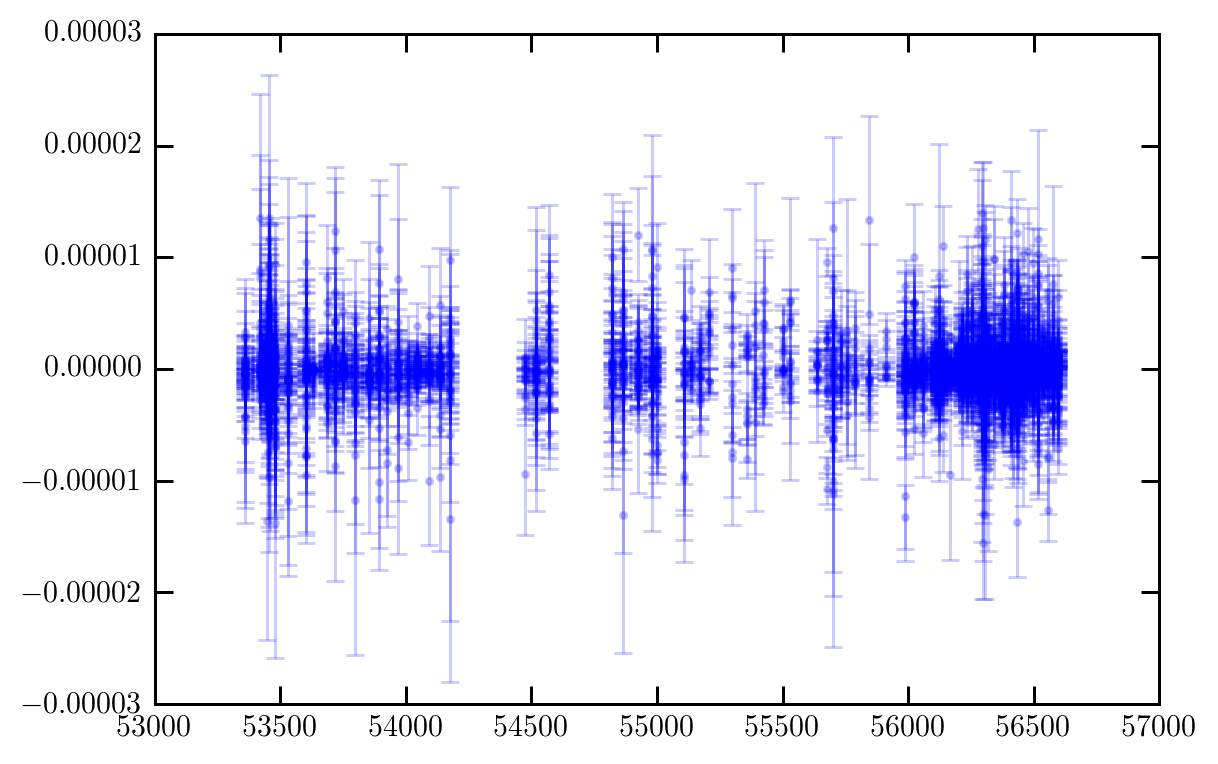

In [114]:
# Check out some plots if you want
plt.errorbar(t2psr[0].toas(),t2psr[0].residuals(),1e-6*t2psr[0].toaerrs,fmt='.',alpha=0.2)

In [115]:
t2psr[0].toaerrs

array([ 1.277,  0.858,  0.897, ...,  1.11 ,  0.657,  2.613])

In [116]:
psr = [NX01_psr.PsrObj(p) for p in t2psr]
[p.grab_all_vars(jitterbin=1.0) for p in psr] # according to the 9 year paper,
                                              # the jitterbin used is 1s

--> Processing B1855+09
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Performing SVD of design matrix for stabilization...
--> Done reading in pulsar :-) 

--> Processing B1937+21
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Performing SVD of design matrix for stabilization...
--> Done reading in pulsar :-) 

--> Processing B1953+29
--> Initial sorting of data.
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Exciz

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [117]:
for ii in range(len(psr)):
    psr[ii].parfile = parfiles[ii] 
    psr[ii].timfile = timfiles[ii]
    psr[ii].noisefile = noisefiles[ii]

In [118]:
for ii,p in enumerate(psr):
    df = NX01_datafile.DataFile(p.name+'.hdf5')
    df.addTempoPulsar(p)
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(psr))
    sys.stdout.flush()

37 of 37


In [ ]:
os.system('mkdir psr_hdf5_files')
os.system('mv *.hdf5 psr_hdf5_files')

## Plot Justin's results and mine

In [77]:
chain_steve = np.loadtxt('/Users/staylor/Research/EPTAv2/UniEQ/NX01/chains_J1909-3744_redloguniform_ptmcmc/chain_1.0.txt')
chain_justin = np.loadtxt('/Users/staylor/Research/EPTAv2/UniEQ/NX01/nano_jellis_validation/J1909-3744/chain_1.txt')

### J1909 first

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1431d2290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x150ec5b10>]], dtype=object)

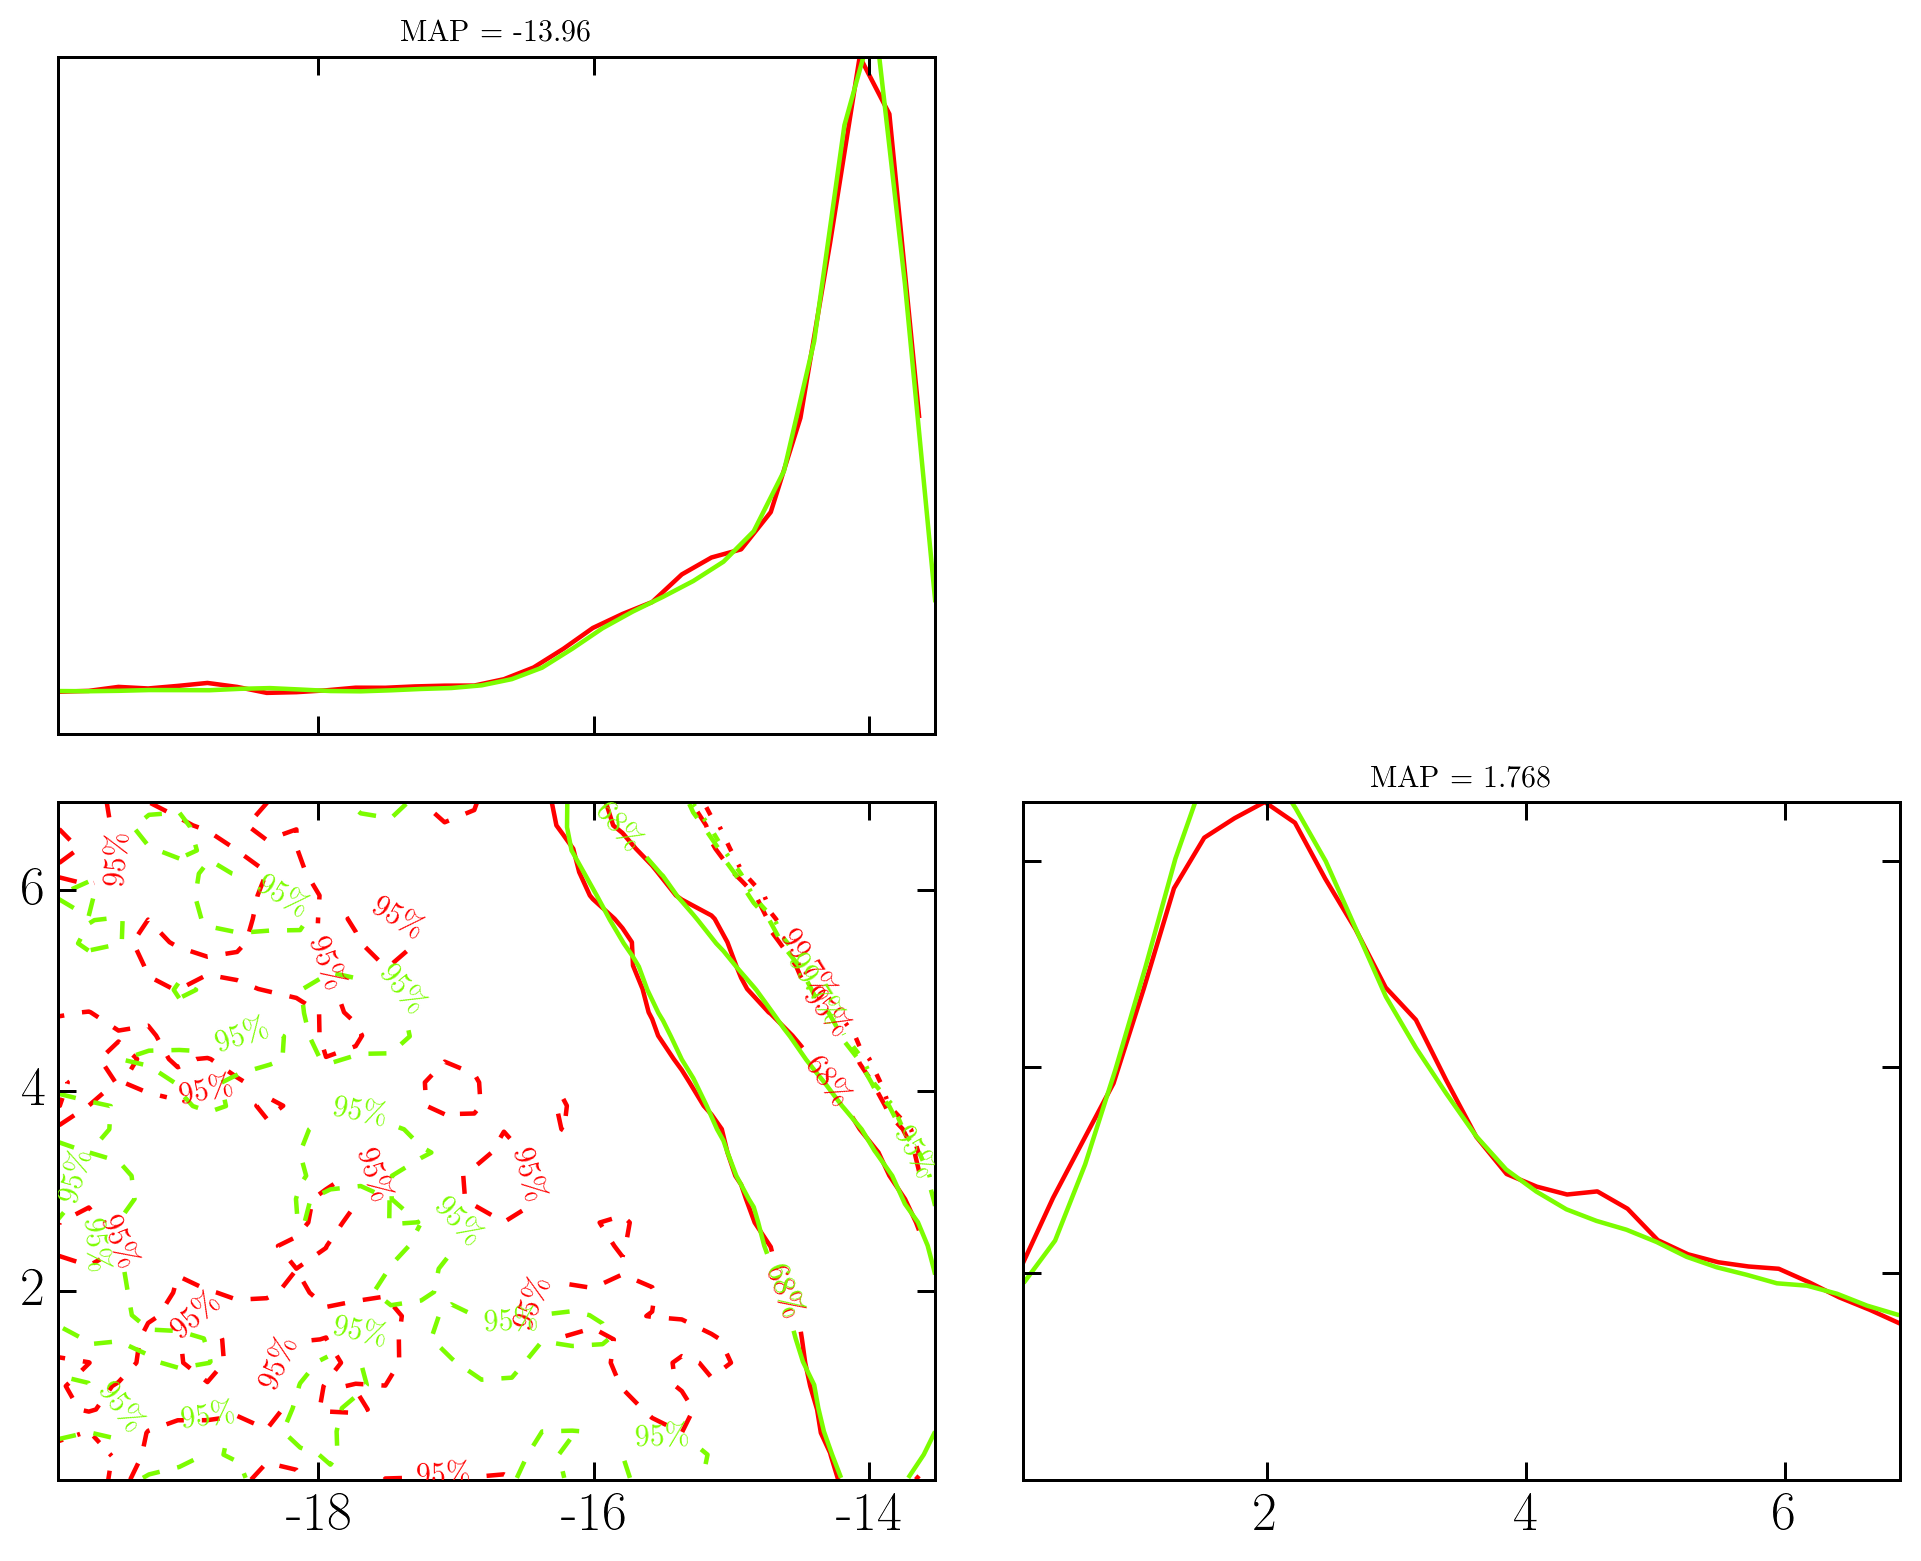

In [78]:
ind = np.array([0,1])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[5000:,[12,13]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1909-3744_red-comp.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14dcba090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x15c937e90>]], dtype=object)

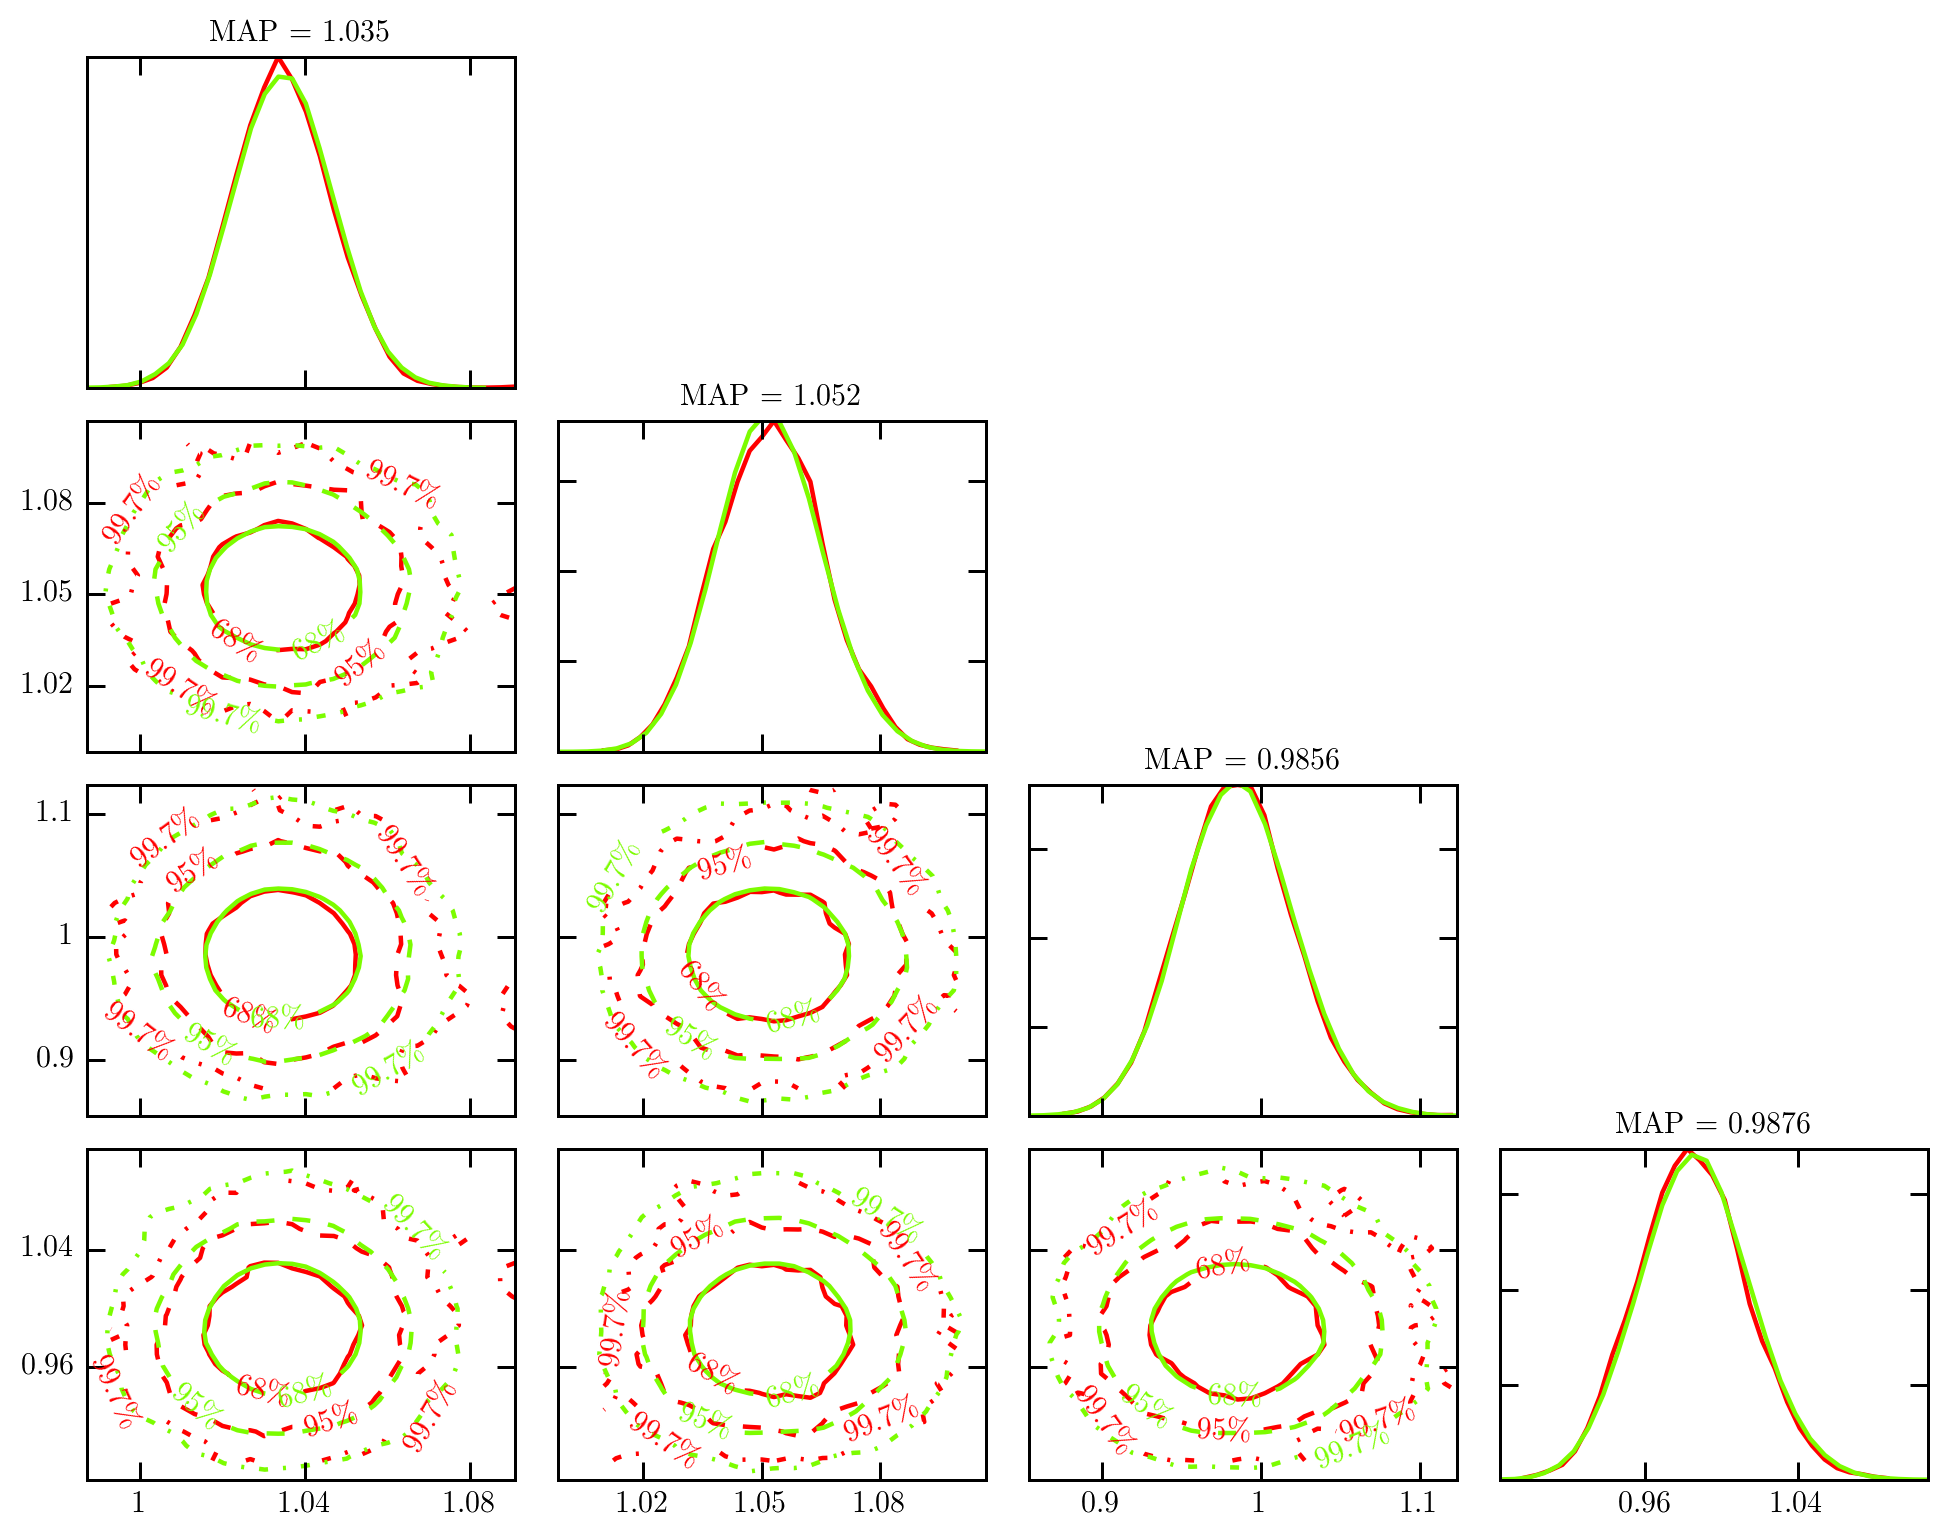

In [79]:
ind = np.array([2,3,4,5])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[5000:,[1,3,0,2]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1909-3744_efac-comp.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1425cbcd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13bdf24d0>]], dtype=object)

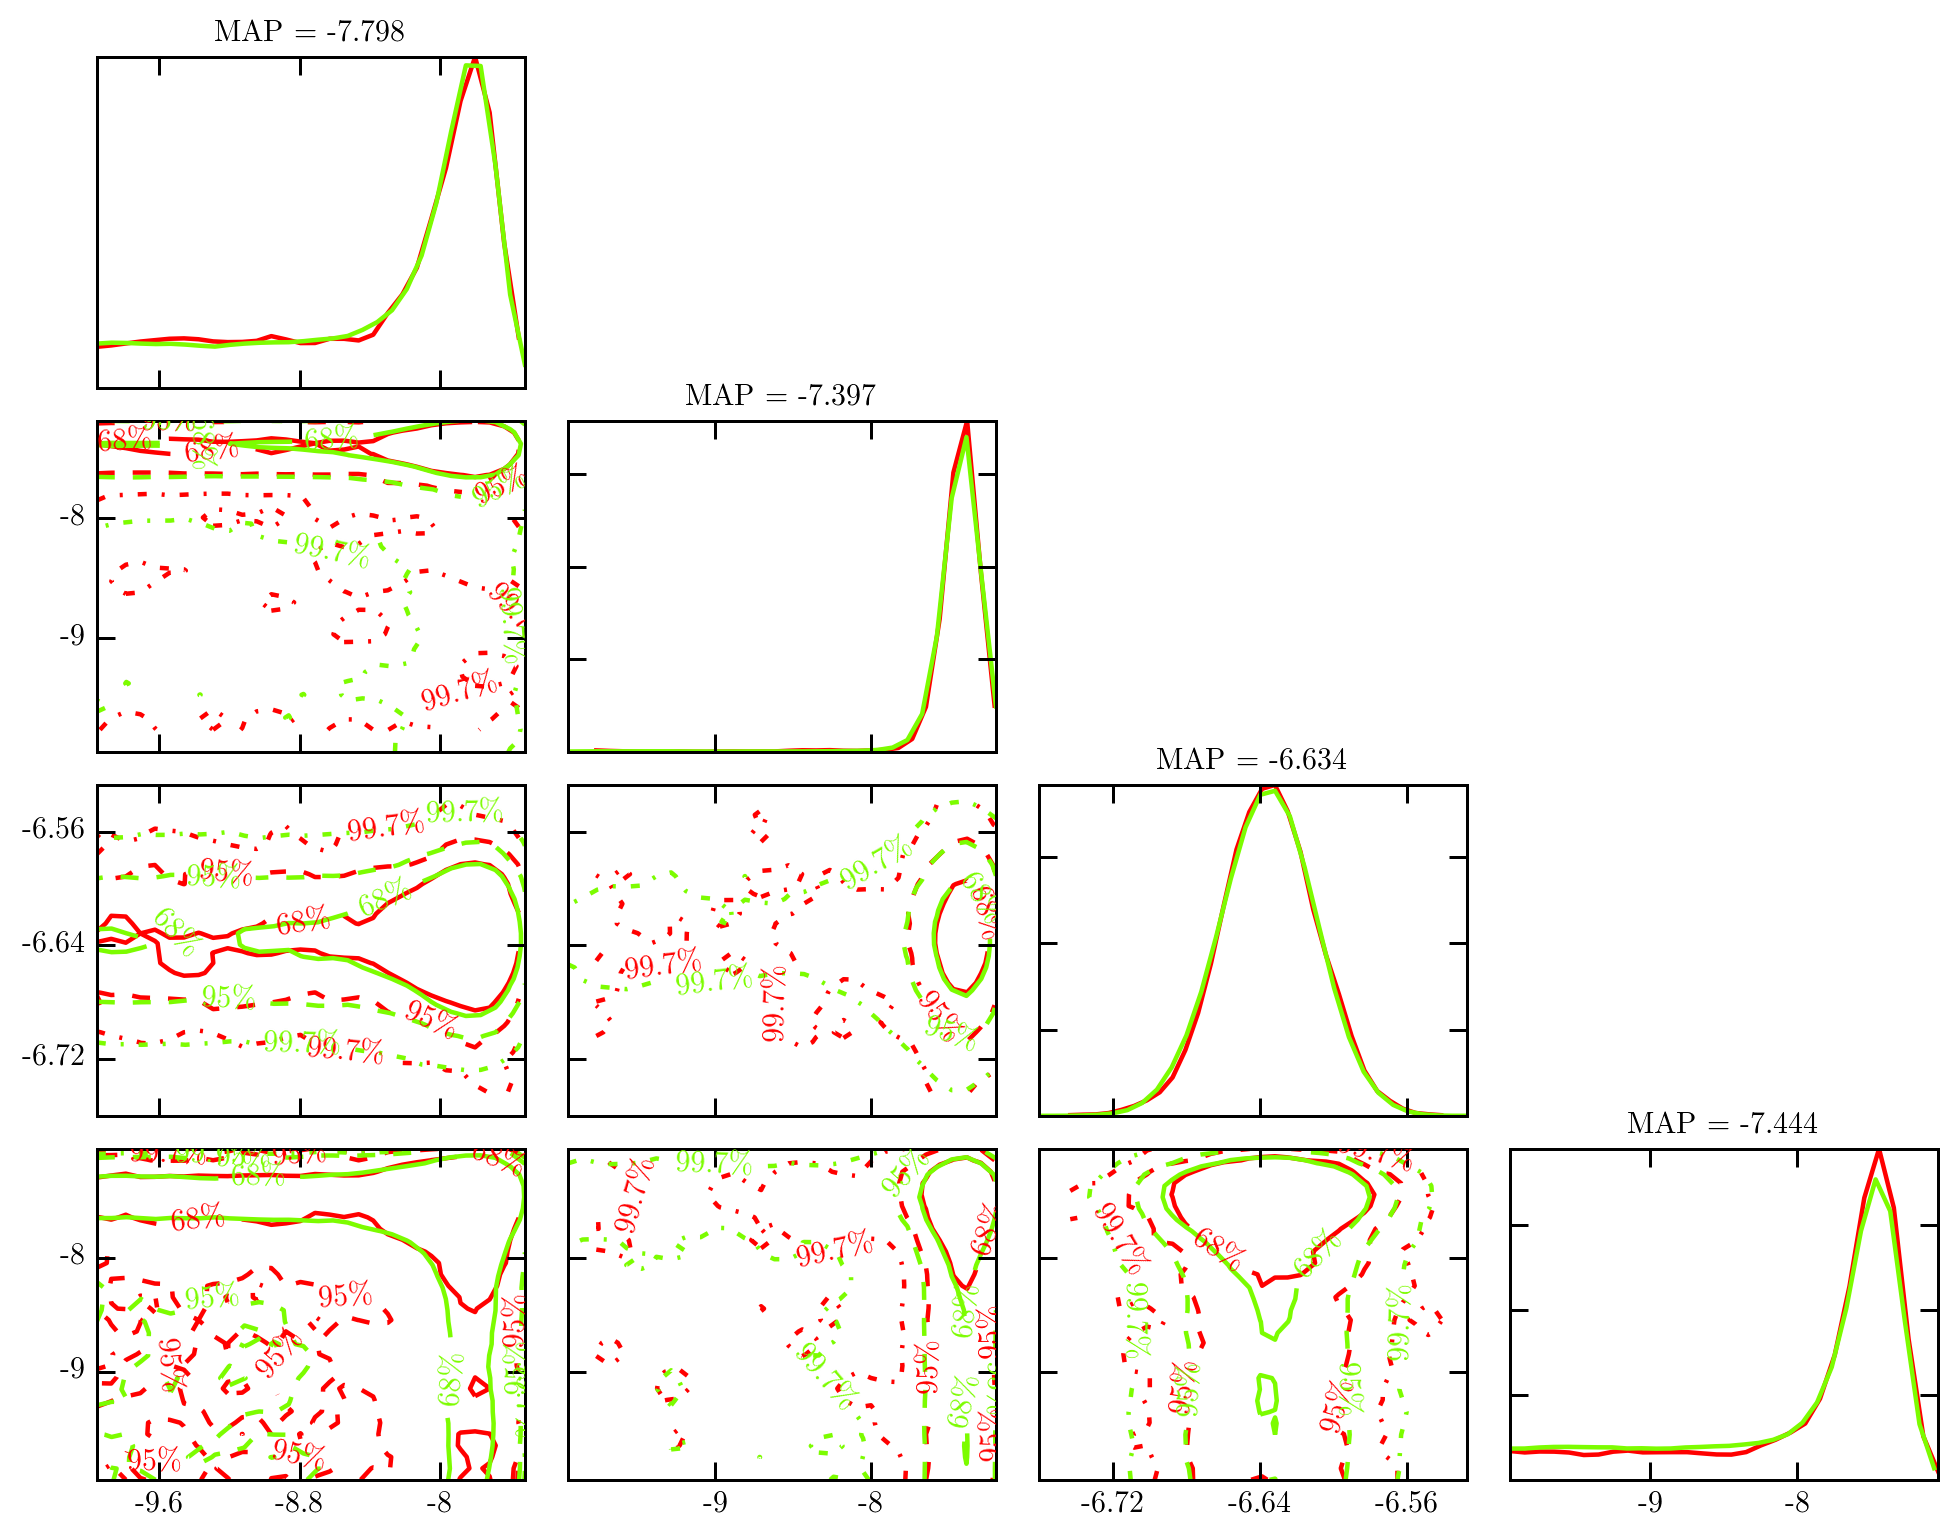

In [80]:
ind = np.array([6,7,8,9])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[5000:,[9,11,8,10]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1909-3744_equad-comp.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x151f78d10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1485d3690>]], dtype=object)

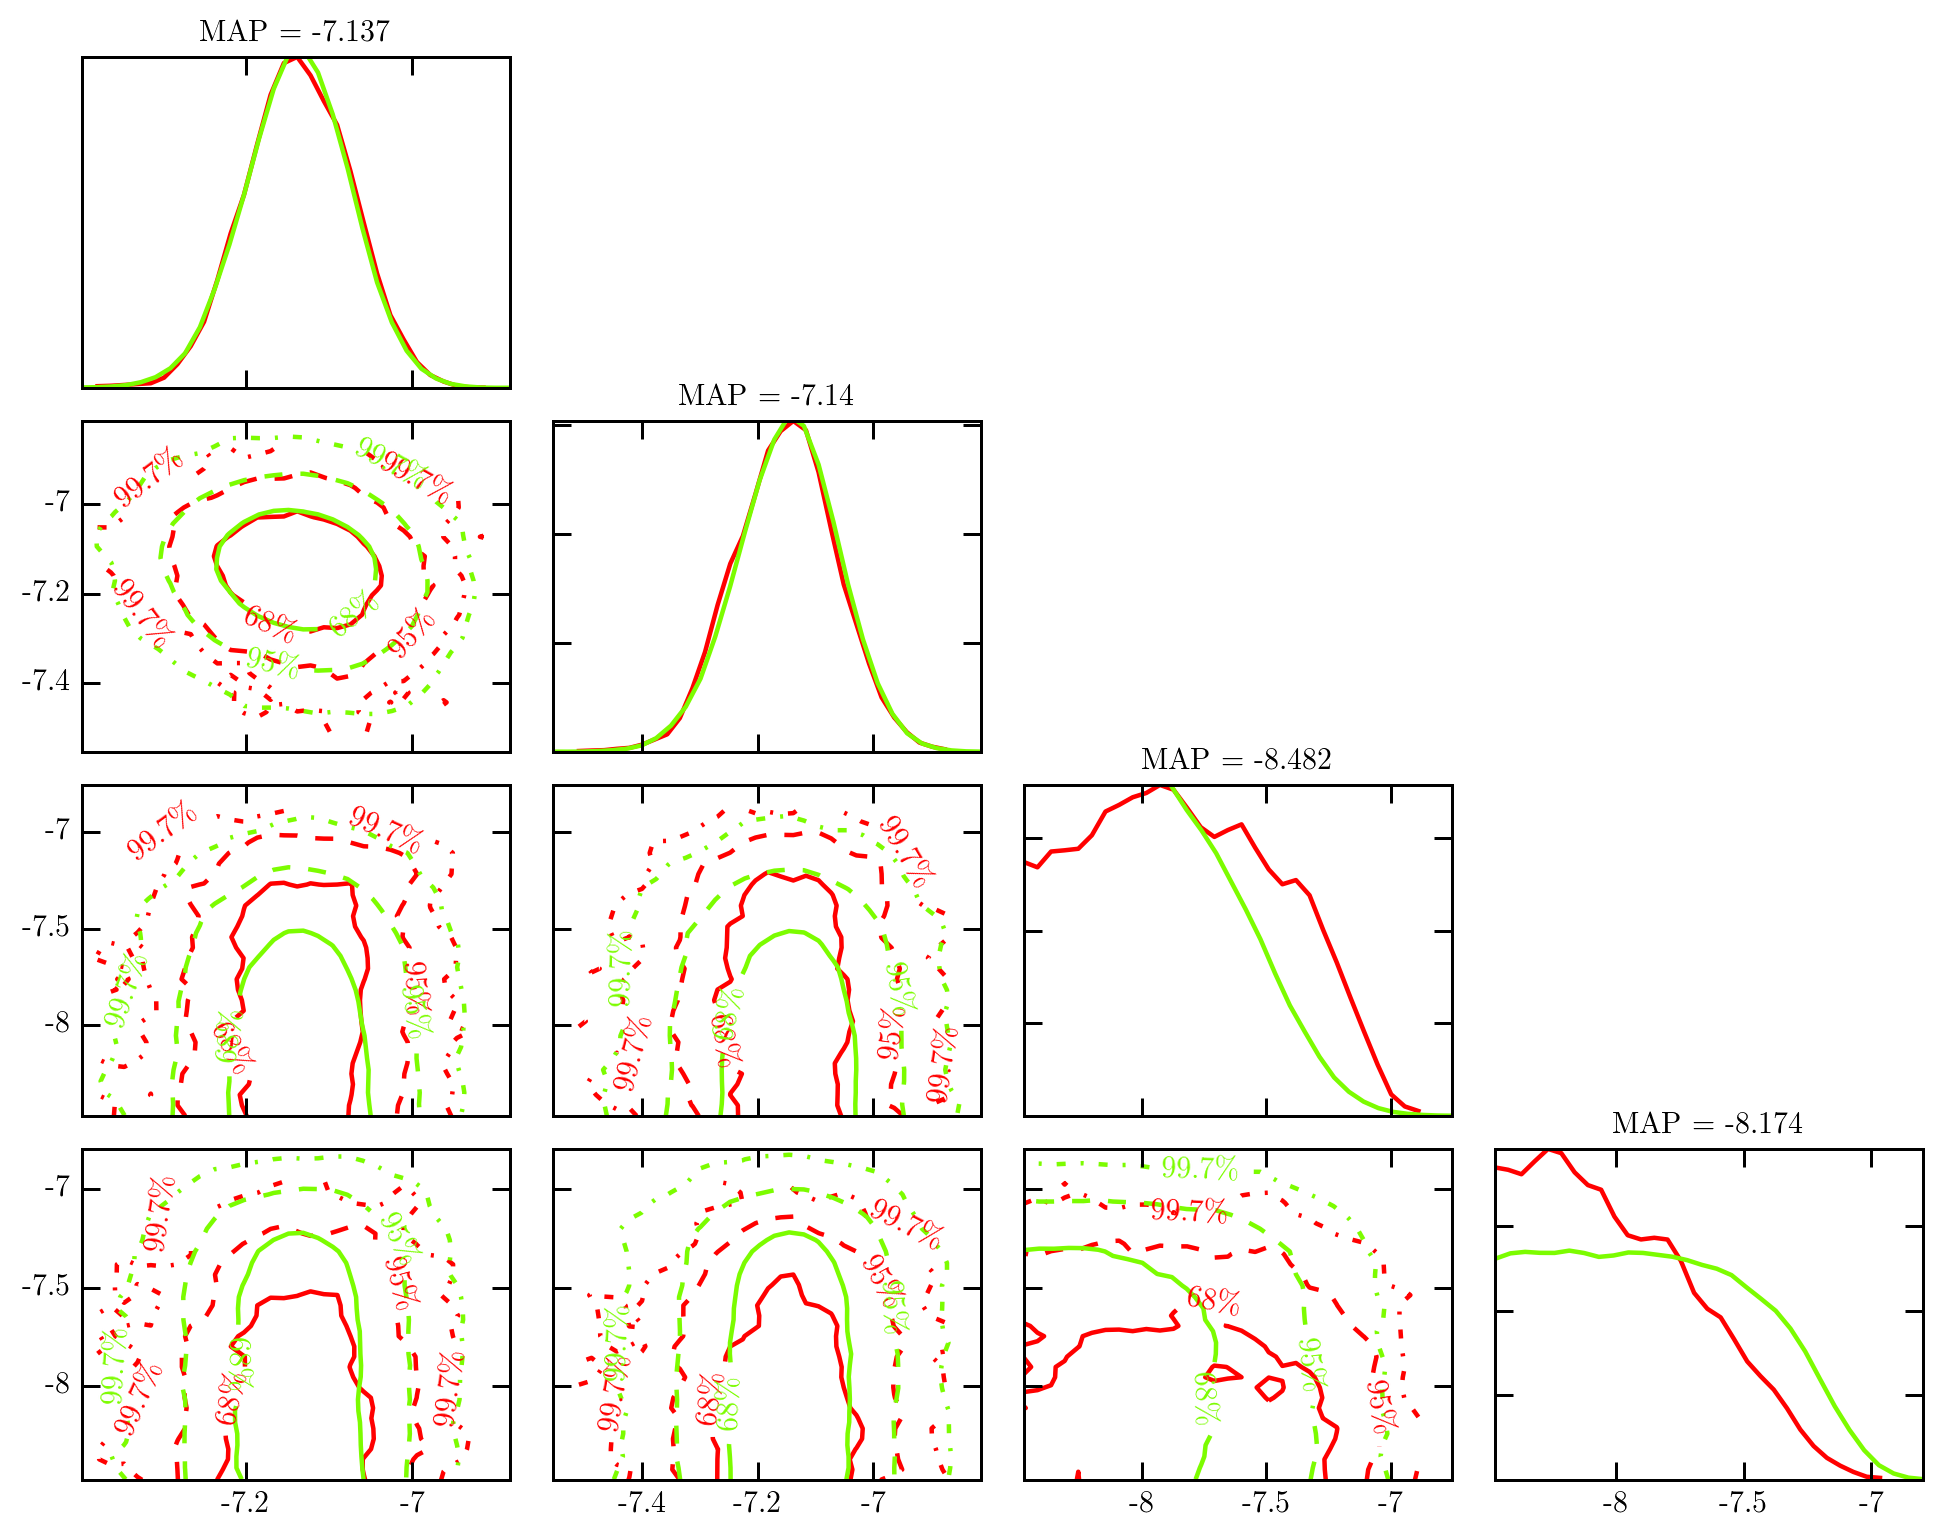

In [81]:
ind = np.array([10,11,12,13])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[5000:,[5,7,4,6]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1909-3744_ecorr-comp.pdf',bbox_inches='tight')

### J1713 now

In [95]:
chain_steve = np.loadtxt('/Users/staylor/Research/EPTAv2/UniEQ/NX01/chains_J1713+0747_redloguniform_ptmcmc/chain_1.0.txt')
chain_justin = np.loadtxt('/Users/staylor/Research/EPTAv2/UniEQ/NX01/nano_jellis_validation/J1713+0747/chain_1.txt')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x197e0b750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x197ca5450>]], dtype=object)

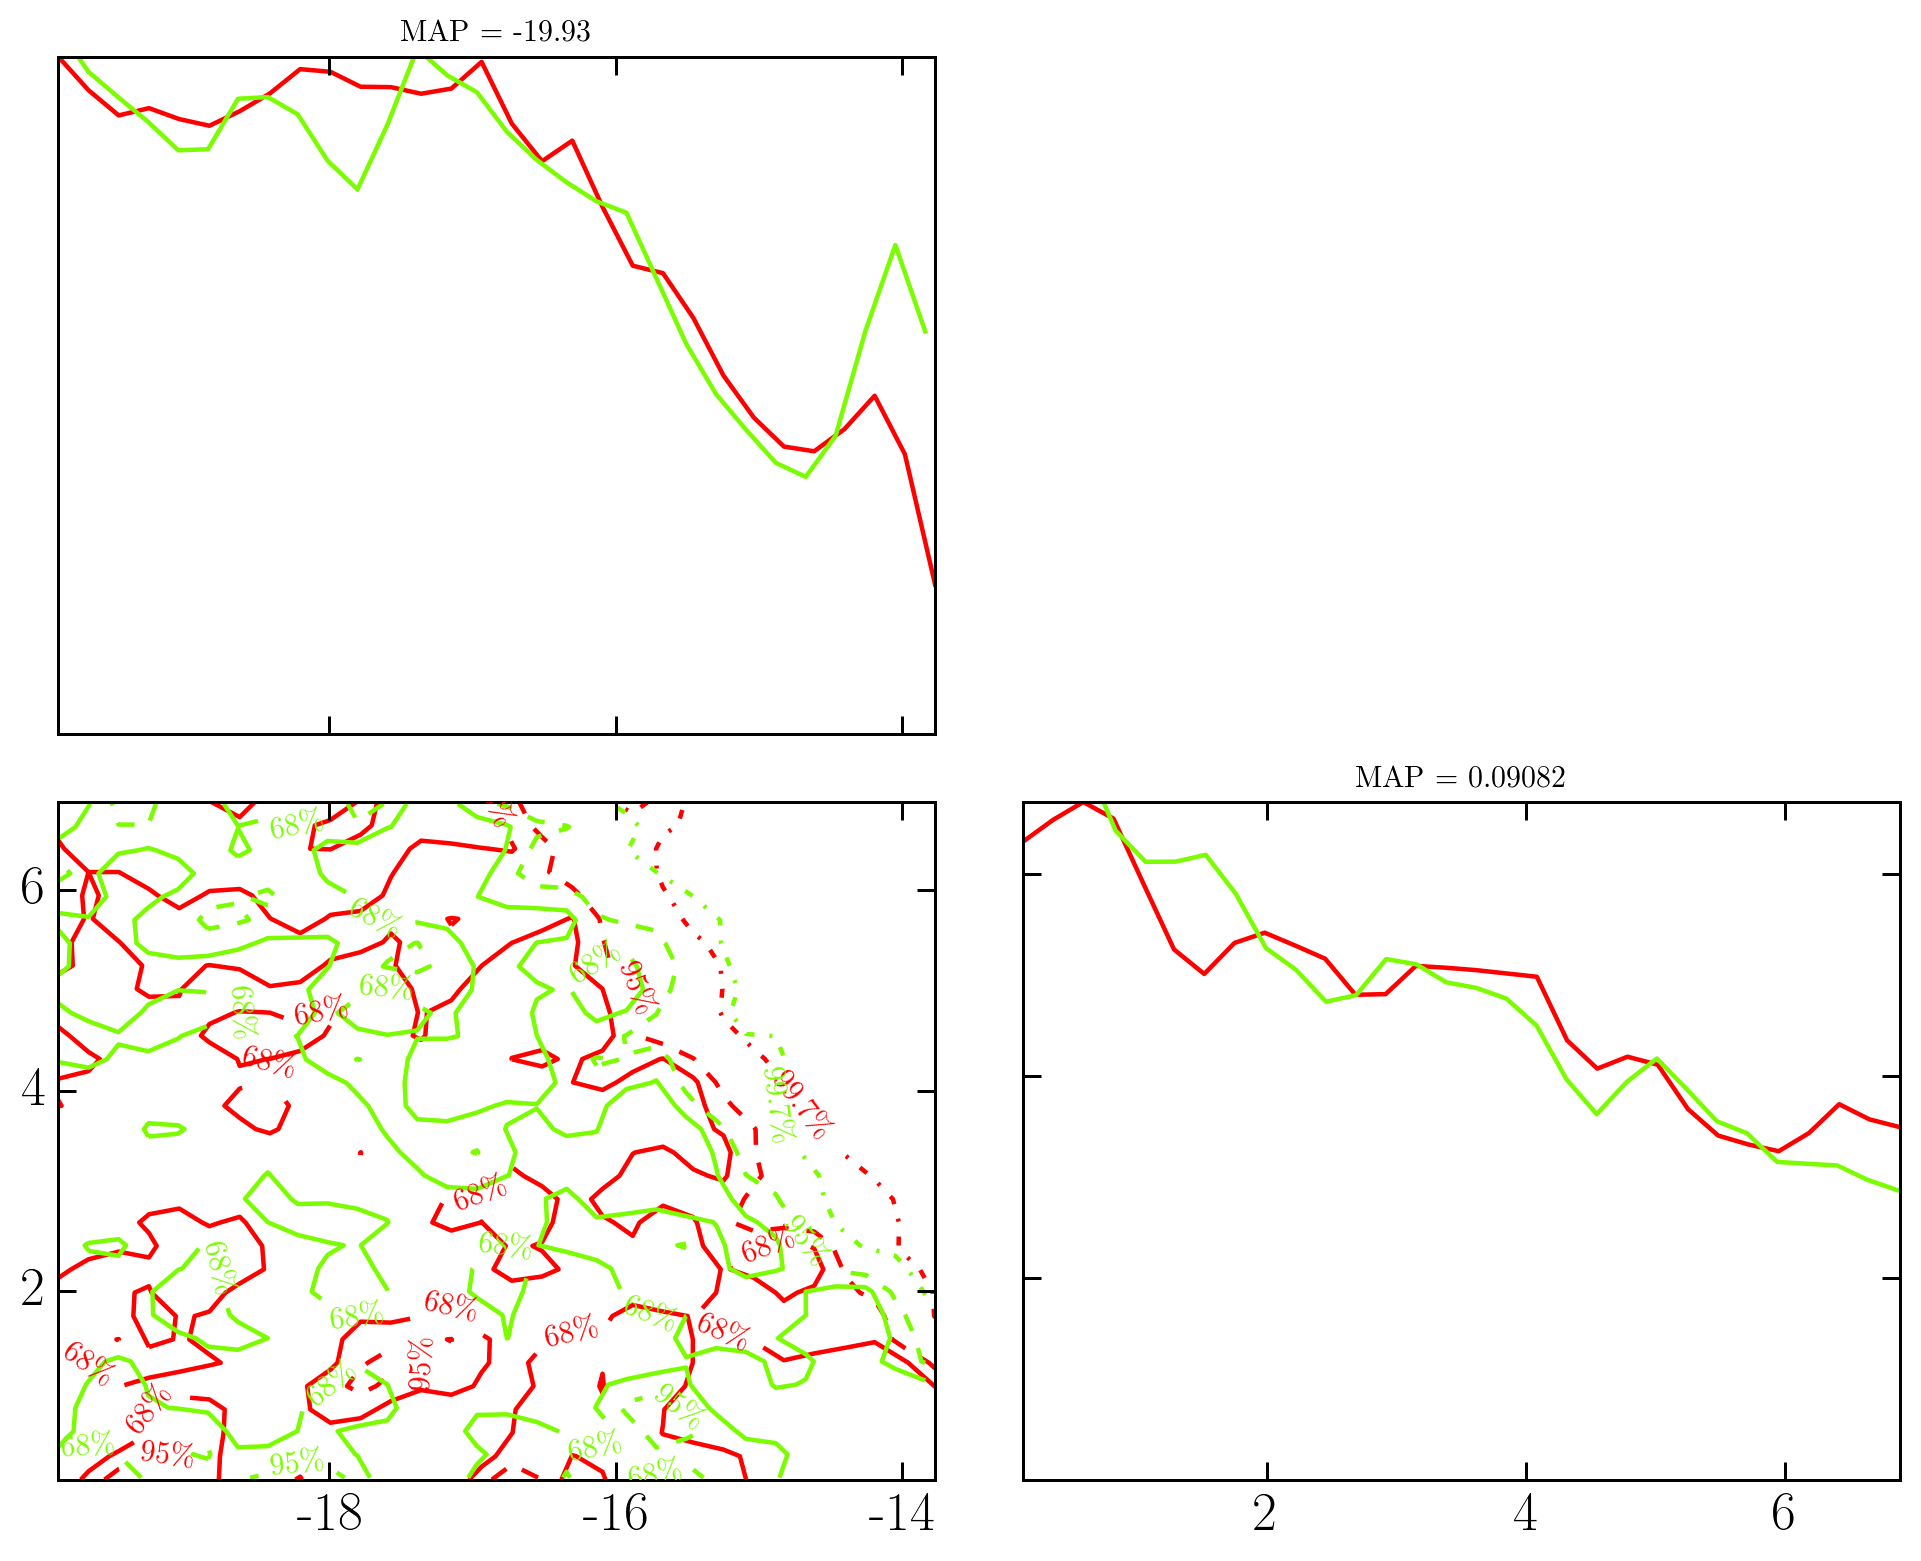

In [97]:
ind = np.array([0,1])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[500:,[24,25]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1713+0747_red-comp.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x197ef7310>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x19cc2a550>]], dtype=object)

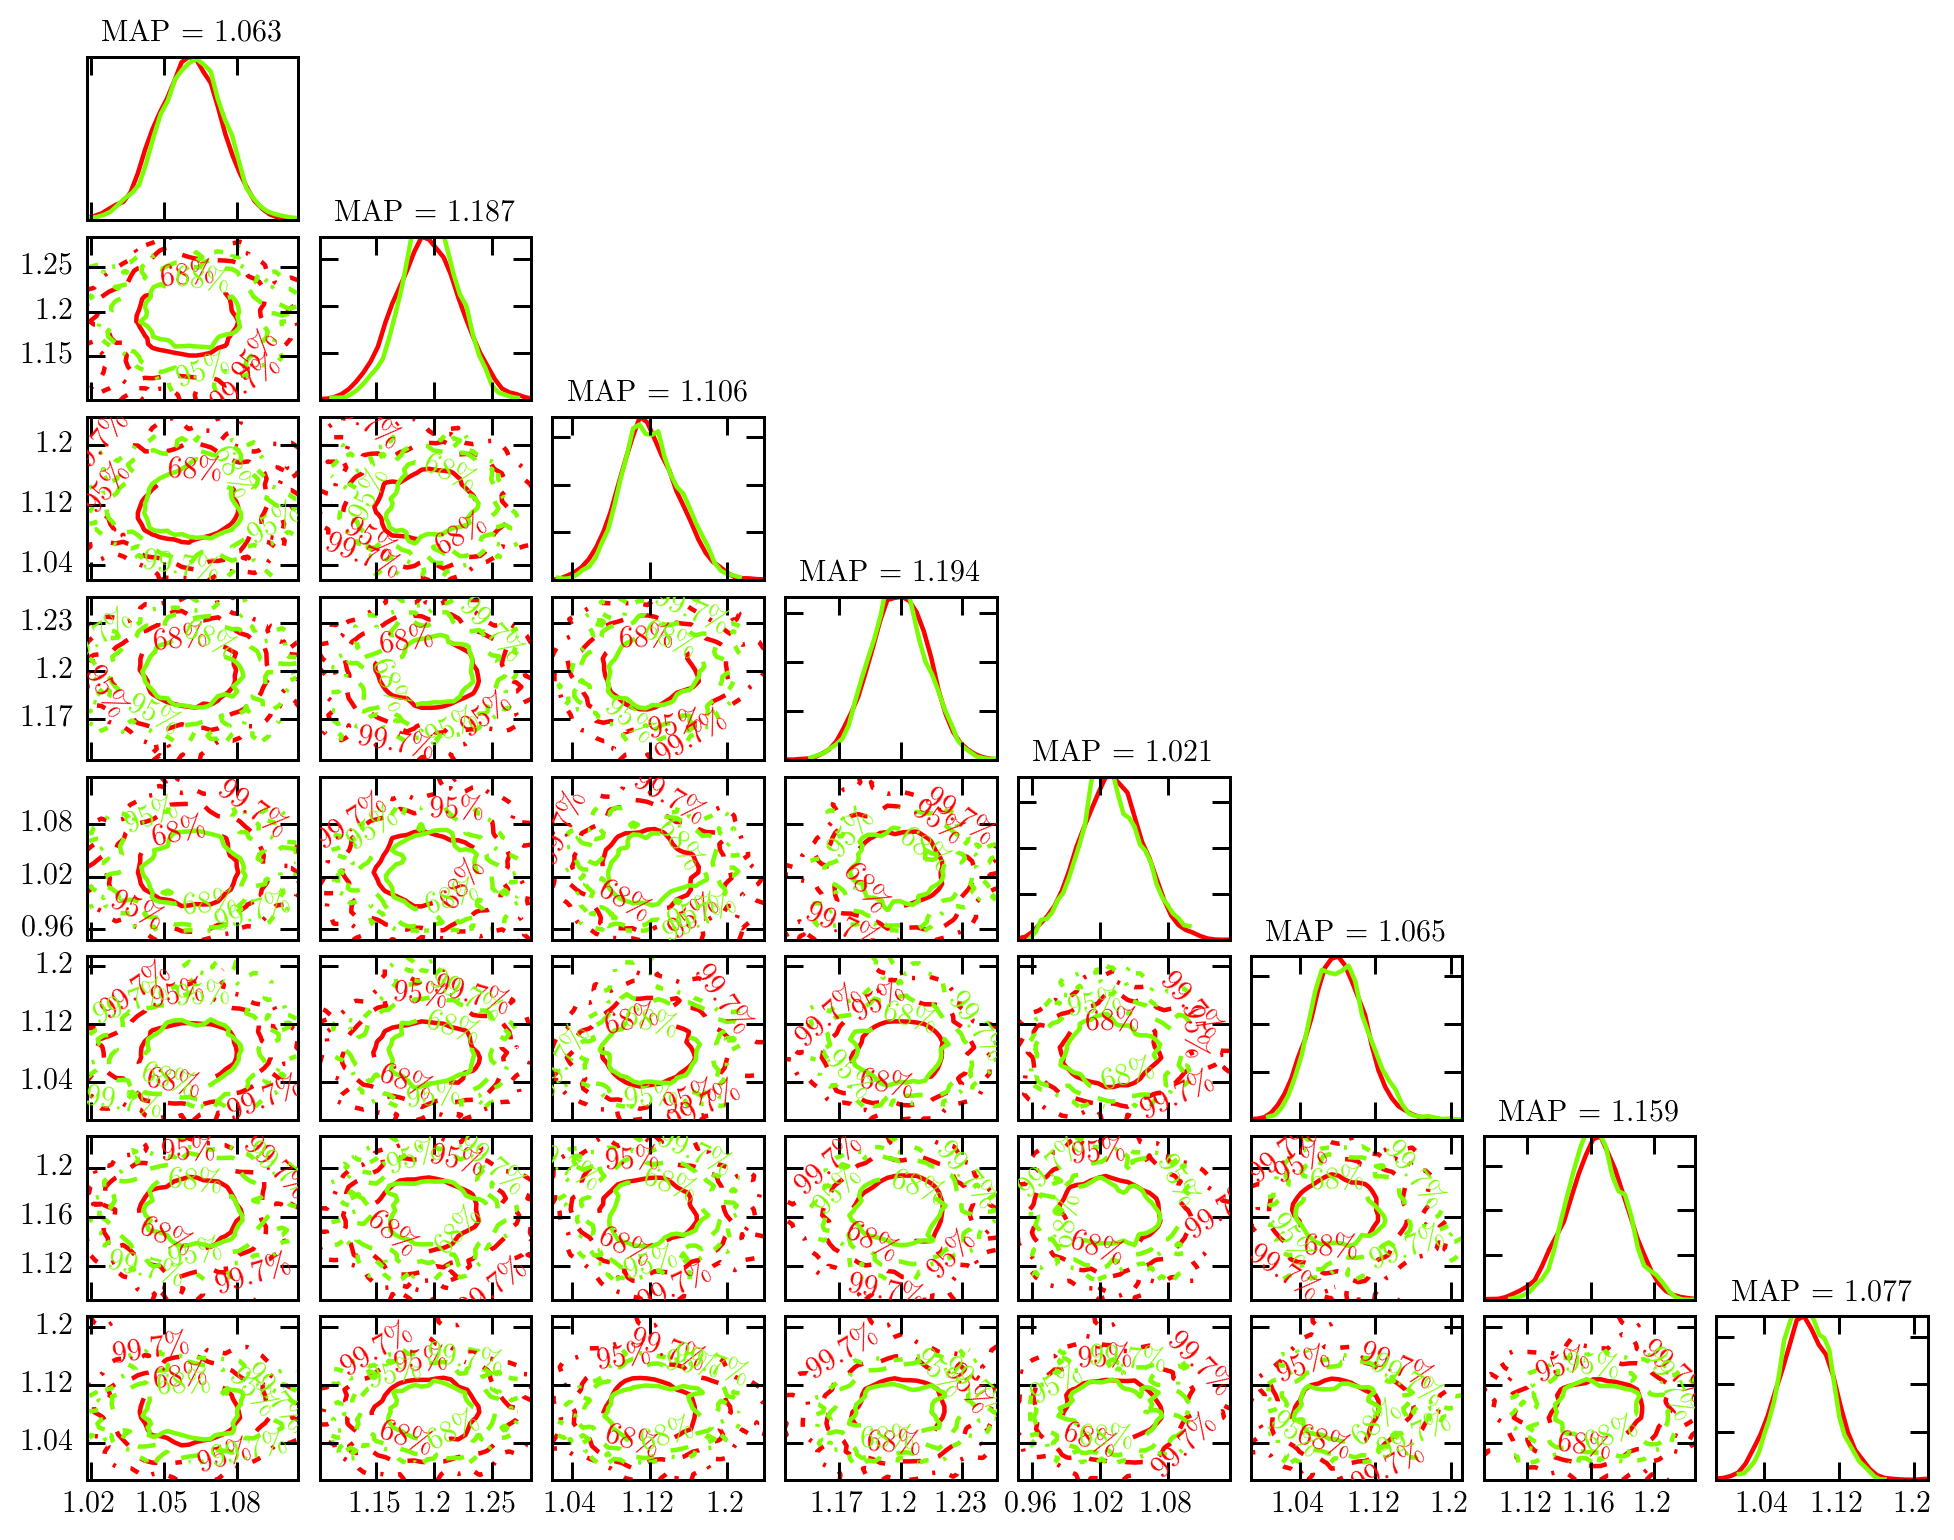

In [98]:
ind = np.array([2,3,4,5,6,7,8,9])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[500:,[0,5,4,3,2,7,6,1]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1713+0747_efac-comp.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x19d6da690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a2e36fd0>]], dtype=object)

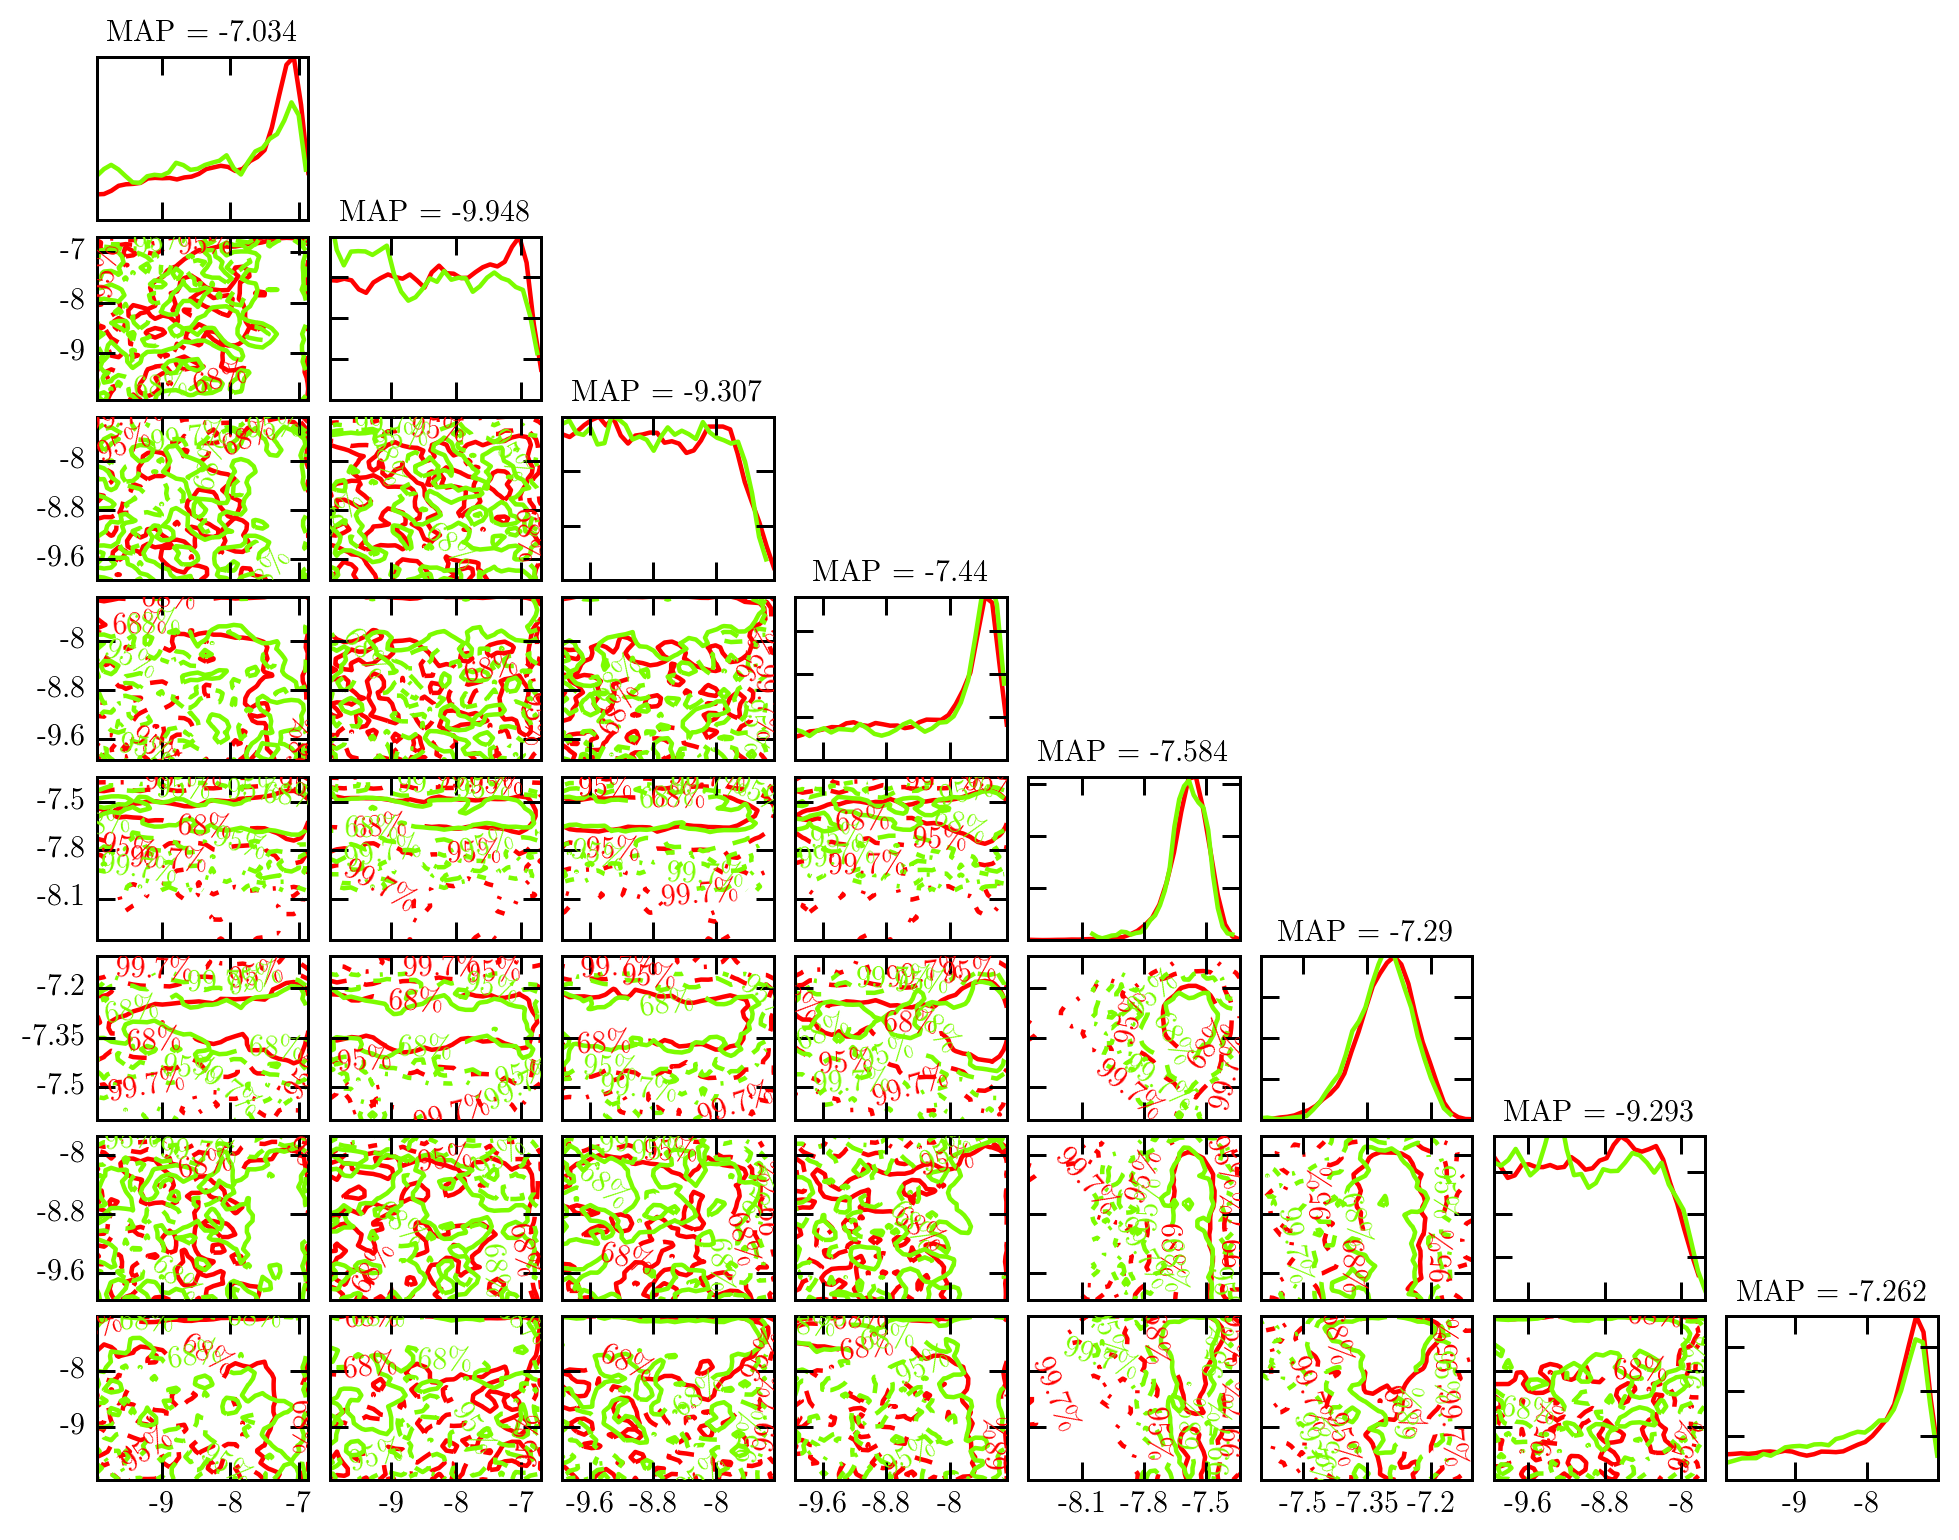

In [99]:
ind = np.array([10,11,12,13,14,15,16,17])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[500:,[16,21,20,19,18,23,22,17]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1713+0747_equad-comp.pdf',bbox_inches='tight')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a774cf10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1aaa55e10>]], dtype=object)

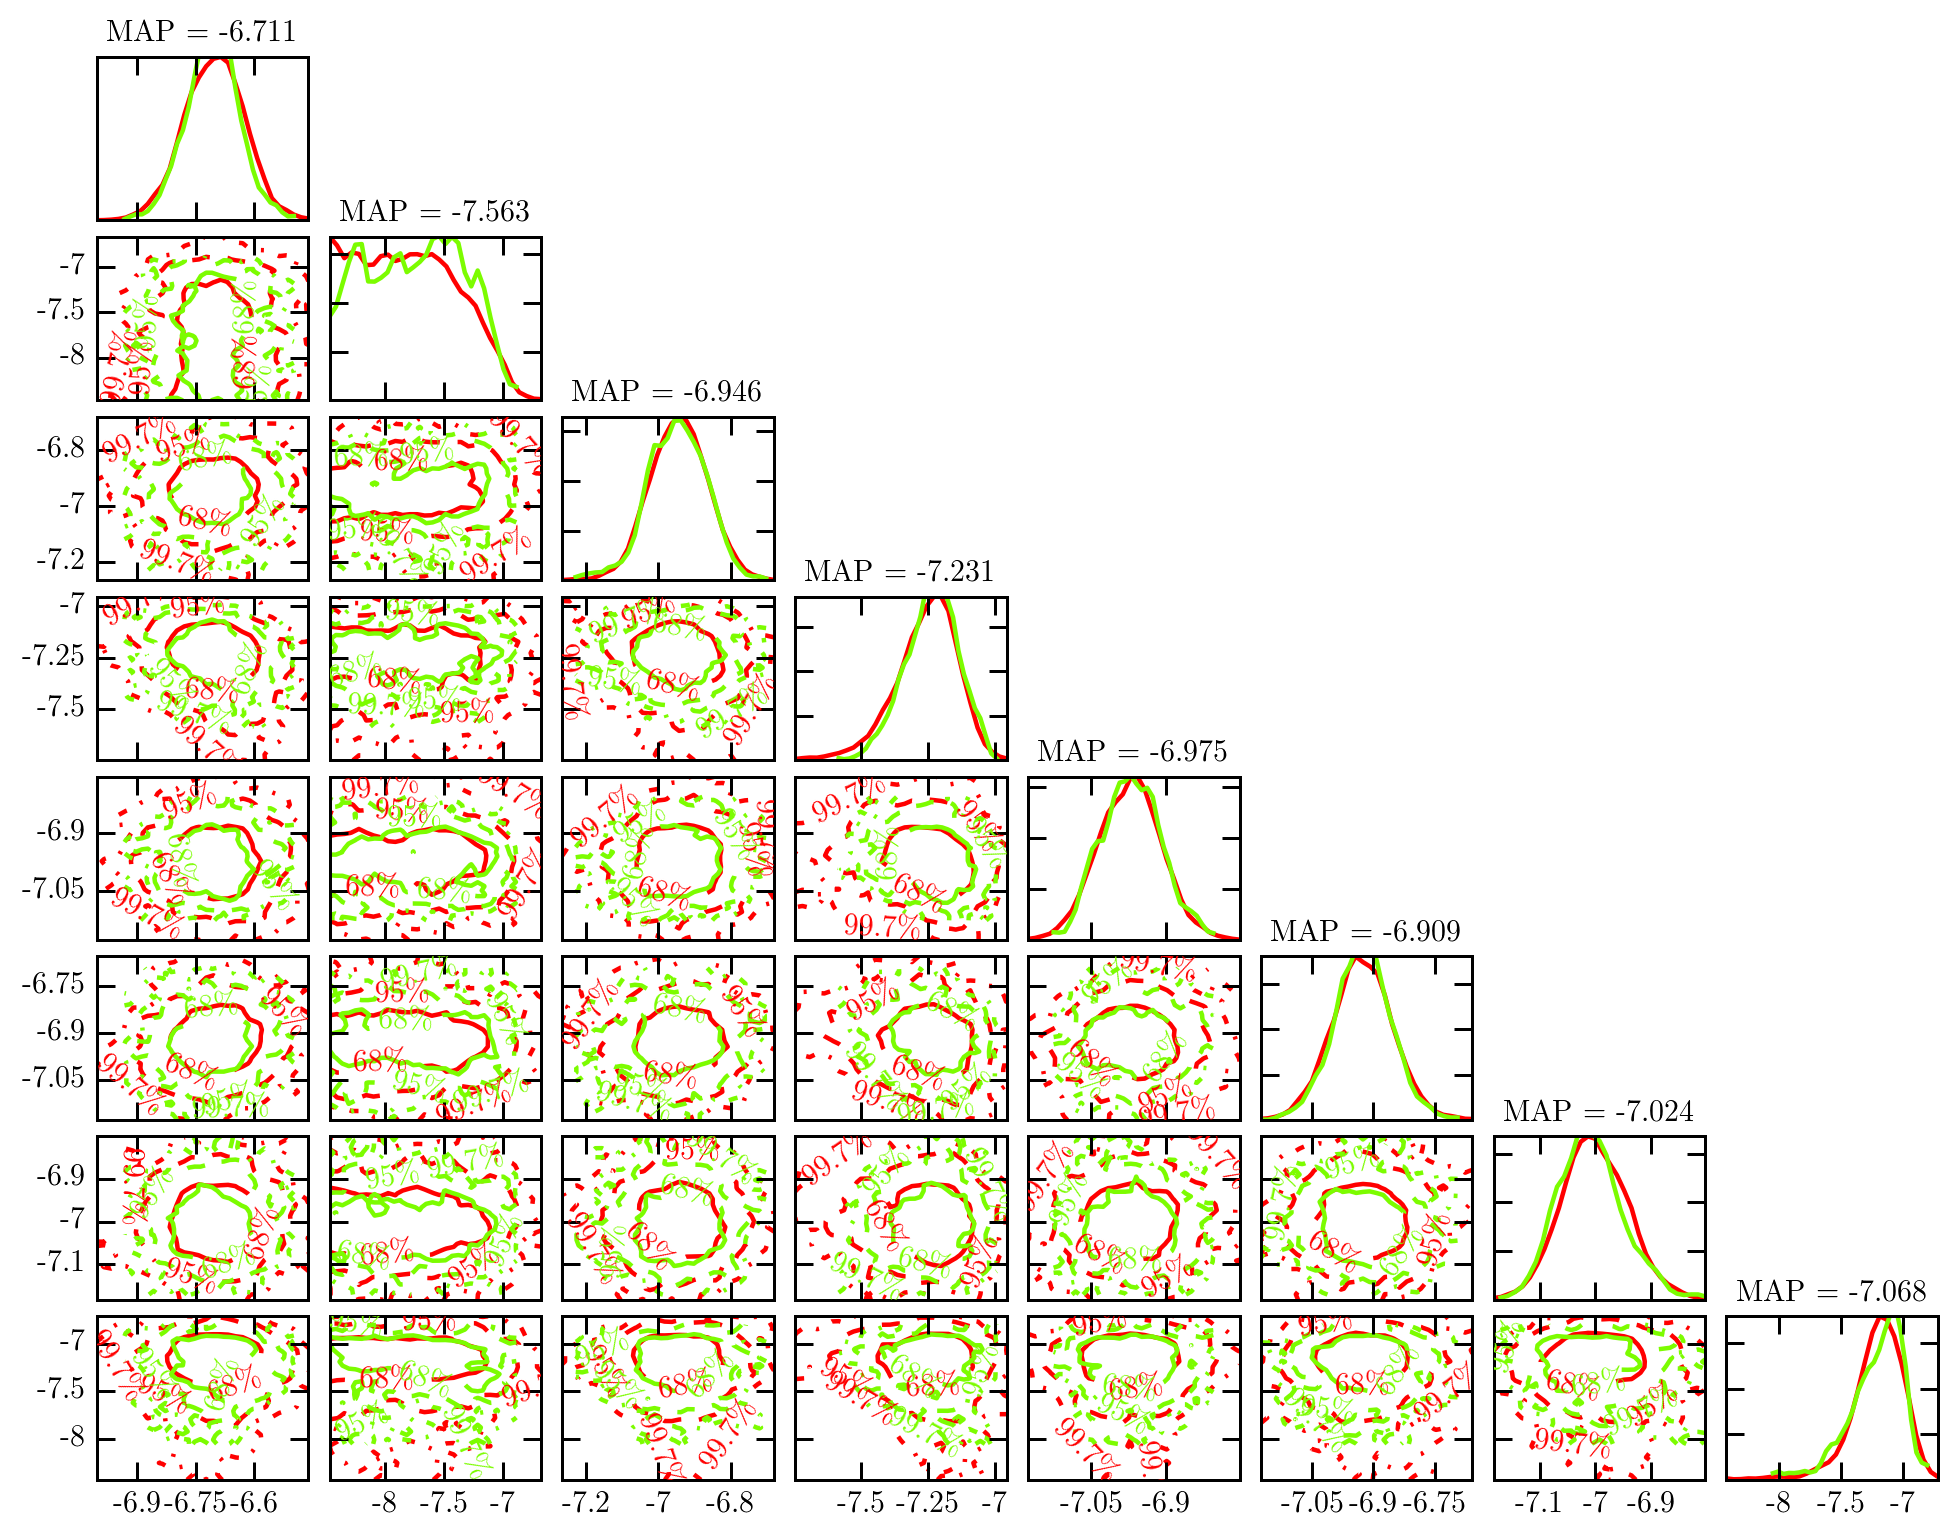

In [101]:
ind = np.array([18,19,20,21,22,23,24,25])
a = bu.triplot(chain_steve[1000:,ind],bins=[30,30],color='red',cmap=None)
bu.triplot(chain_justin[500:,[13,12,14,11,8,15,9,10]],gcf_axarr=a,bins=[30,30],color='lawngreen',cmap=None,holdon=True)

#plt.savefig('J1713+0747_ecorr-comp.pdf',bbox_inches='tight')

### Now, let's get some GWB limits

In [70]:
chain_gwb = np.loadtxt('./chains_nanoAnalysis/nanograv_gwblimit_noCorr_gam4p33_redlimit_nmodes15/chain_1.0.txt')

In [71]:
10.0**np.array(bu.confinterval(chain_gwb[15000:,36],sigma=0.95,onesided=True))

array([  4.25332574e-17,   1.45036227e-15])

In [72]:
from statsmodels.distributions.empirical_distribution import ECDF

In [73]:
ecdf = ECDF(10.0**chain_gwb[:,36])

In [74]:
amp = np.linspace(1e-16,1e-14,1000)

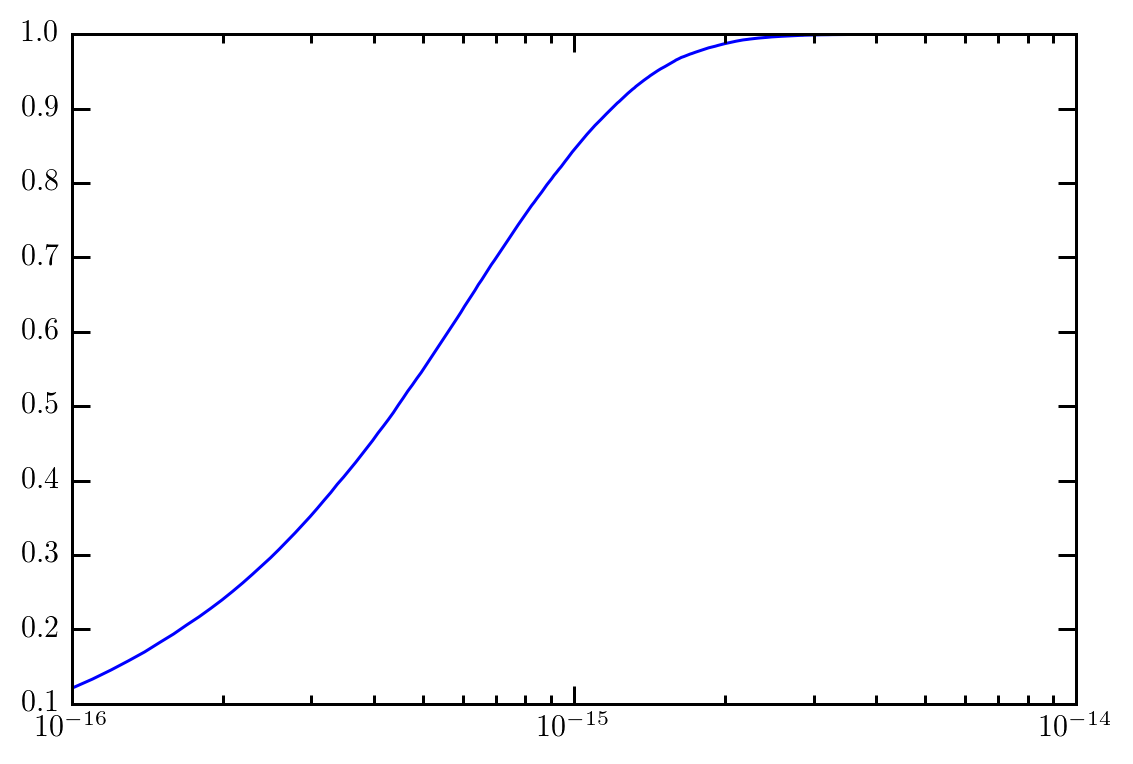

In [75]:
plt.plot(amp,ecdf(amp))
plt.xscale('log')

In [79]:
ecdf(1.47e-15)

0.9512612612612612